In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import seaborn as sns
import csv

In [2]:
games = pd.read_excel('../Results.xlsx', sheet_name='Games')
turns = pd.read_excel('../Results.xlsx', sheet_name='Turns')
pvp_games = games.query('GameState == "END" and idPerson1 not in [10, 30, 203, 217]'
                        ' and idPerson2 not in [10, 30, 203, 217] and not idGame == 1650')
pvp_games_ids = pvp_games['idGame']

In [8]:
pvp_game_i_turns

,Games_idGame,idTurn,Turn,State,AddedTime
2997,169,0,"[0,0]","[8,8]",2020-10-06 22:45:20
2998,169,1,"[0,1]","[9,8]",2020-10-06 22:45:20
2999,169,2,"[0,0]","[9,7]",2020-10-06 22:45:20
3000,169,3,"[1,1]","[8,7]",2020-10-06 22:45:20
3001,169,4,"[1,0]","[8,8]",2020-10-06 22:45:20
...,...,...,...,...,...
3076,169,79,"[1,0]","[14,13]",2020-10-06 22:45:20
3077,169,80,"[0,1]","[15,13]",2020-10-06 22:45:20
3078,169,81,"[1,0]","[15,14]",2020-10-06 22:45:20
3079,169,82,"[1,0]","[15,15]",2020-10-06 22:45:20


In [62]:
pvp_games_turns = []
pvp_games_states = []
pvp_games_choices = []
pvp_games_turns_timestamps = []
for i in pvp_games_ids:
    pvp_game_i_turns = turns.query('Games_idGame == ' + str(i))
    pvp_games_choices.append(pvp_game_i_turns.sort_values(by='idTurn')['Turn'])
    pvp_games_turns_timestamps.append(pvp_game_i_turns.sort_values(by='idTurn')['AddedTime'])
    for state in (pvp_game_i_turns.sort_values(by='idTurn'))['State']:
        pvp_games_states.append(state)
    pvp_games_turns.append(max(pvp_game_i_turns['idTurn']))

In [68]:
from compute_games_time import compute_games_time
all_time = 2 * compute_games_time(pvp_games_turns_timestamps)
print(all_time / 3600)

167.71833333333333


# Cross-correlations of choices

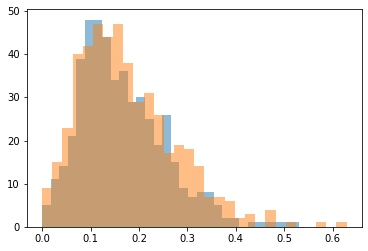

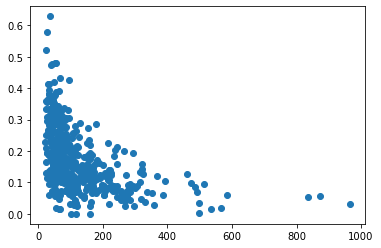

In [22]:
from digitalize_states import digitalize_states
max_corrs_left = []
max_corrs_right = []
corr_turn = []
for pvp_game_choices in pvp_games_choices:
    if len(pvp_game_choices) < 20:
        continue
    choices = digitalize_states(pvp_game_choices)
    cont_table = np.zeros((2, 2), dtype=np.int32)
    for i, j in choices:
        cont_table[i, j] += 1
    choices = np.array(choices).T
    import scipy
    choices = choices * 2 - 1
    c = np.correlate(choices[0].astype('float64'), choices[1].astype('float64'), 'full') / len(choices[0])
    max_corr_left = 0
    max_corr_right = 0
    for lag in range(1, 10 + 1):
        max_corr_left = max(max_corr_left, c[len(c) // 2 + lag])
        max_corr_right = max(max_corr_right, c[len(c) // 2 - lag])
    max_corrs_left.append(max_corr_left)
    max_corrs_right.append(max_corr_right)
    corr_turn.append(len(pvp_game_choices))
plt.hist(max_corrs_left, 30, alpha=0.5)
plt.hist(max_corrs_right, 30, alpha=0.5)
plt.figure()
#plt.scatter(max_corrs_left, max_corrs_right)
plt.scatter(corr_turn, max_corrs_right)

In [5]:
from get_prob_matrix import get_prob_matrix
from get_prob_matrix_symmetry import get_prob_matrix_symmetry
from get_fundamental_matrix import get_fundamental_matrix
from get_mean_time import get_mean_time
from get_games_strategy import get_games_strategy
from get_games_hist_2d import get_games_hist_2d

In [6]:
N = 16

hist_2d_inner, hist_2d_border = get_games_hist_2d(N, pvp_games_states)
pvp_pmf = np.bincount(pvp_games_turns, minlength=10000) / len(pvp_games_turns)
qr, probability_matrix, counts = get_prob_matrix(N, pvp_games_states, return_counts=True)
qr_symm, probability_matrix_symm = get_prob_matrix_symmetry(N, pvp_games_states)
fundamental_matrix = get_fundamental_matrix(probability_matrix)
fundamental_matrix_symm = get_fundamental_matrix(probability_matrix_symm)
mean_time = get_mean_time(N - 1, fundamental_matrix)
mean_time_symm = get_mean_time(N - 1, fundamental_matrix_symm)

print("mean time: ", mean_time)
print("mean time symm: ", mean_time_symm)

strategy_border, strategy_center = get_games_strategy(N, pvp_games_states)

np.save('../data/qr_counts_pvp.npy', counts)
np.save('../data/qr_pvp.npy', qr)
np.save('../data/qr_pvp_symm.npy', qr_symm)
np.save('../data/strategy_pvp_border.npy', strategy_border)
np.save('../data/strategy_pvp_center.npy', strategy_center)
np.save('../data/experiment_pvp_pmf.npy', pvp_pmf)
np.save('../data/experiment_pvp_hist_2d_inner.npy', hist_2d_inner)
np.save('../data/experiment_pvp_hist_2d_border.npy', hist_2d_border)


even = 0
odd = 0
for i in pvp_games_turns:
    if i % 2 == 0:
        even +=1
    else:
        odd +=1 
print(even / len(pvp_games_turns))
print(odd / len(pvp_games_turns))

mean time:  120.59919839679375
mean time symm:  120.59919839679334
0.3527054108216433
0.6472945891783567


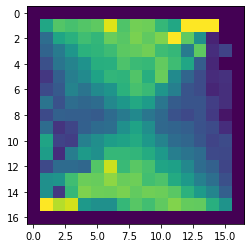

In [6]:
plt.imshow(strategy_border)

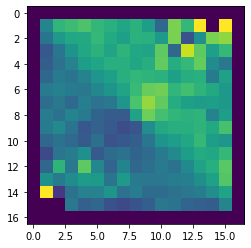

In [8]:
plt.imshow(strategy_center)

In [15]:
np.mean(pvp_games_turns)

120.59919839679358

In [6]:
with open("q.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(probability_matrix)
with open("q_symm.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(probability_matrix_symm)

with open("qr.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(qr)
with open("qr_symm.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(qr_symm)    
    
with open("fundamental.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(fundamental_matrix)
with open("fundamental_symm.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(fundamental_matrix_symm)

In [124]:
# heatmap
from digitalize_states import digitalize_states
from convert_games2states import convert_games2states
from get_all_games import get_all_games
from get_game_trajectories import get_game_trajectories

states = digitalize_states(pvp_games_states)

pvp_states = np.empty((17,17))
for i in range(0, 17):
    for j in range (0, 17):
        pvp_states[i, j] = states.count((i, j)) / len(states)


pvp_states_symm = convert_games2states(get_all_games(N, get_game_trajectories(states)))
pvp_symm = np.empty((17, 17))
for i in np.arange(0, 17):
    for j in np.arange (0, 17):
        pvp_symm[i, j] = pvp_states_symm.count((i, j)) / len(pvp_states_symm)

In [131]:
# for trajectories
from find_closest import find_closest
from write_states2csv import write_states2csv

games = get_game_trajectories(states)

k = 0
for i in range (0, 7):
    k += ((-1) ** i) * i
    closest2short_index = int(find_closest(np.quantile(pvp_games_turns, 0.25) + k, pvp_games_turns))
    closest2mean_index = int(find_closest(mean_time + k, pvp_games_turns))
    closest2long_index = int(find_closest(np.quantile(pvp_games_turns, 0.75) + k, pvp_games_turns))
    
    short_game = games[closest2short_index]
    regular_game = games[closest2mean_index]
    long_game = games[closest2long_index]
    
    write_states2csv("PvP", "short", short_game, i)
    write_states2csv("PvP", "regular", regular_game, i)
    write_states2csv("PvP", "long", long_game, i)

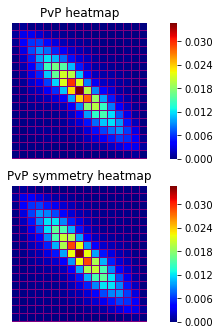

In [95]:
fig, axes = plt.subplots(2, figsize=(8.27, 5.5))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(pvp_states, cmap='jet', linecolor='purple', 
            linewidth=0.05, ax=axes[0], square=True, xticklabels=False, yticklabels=False)
axes[0].set_title("PvP heatmap")
sns.heatmap(pvp_symm, cmap='jet', linecolor='purple', 
            linewidth=0.05, ax=axes[1], square=True,  xticklabels=False, yticklabels=False)
axes[1].set_title("PvP symmetry heatmap")
plt.show()

In [6]:
from generate_distribution import generate_distribution

In [11]:
gen_turns, sample_games = generate_distribution(N, qr)
gen_turns_symm, sample_games_symm = generate_distribution(N, qr_symm)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:44<00:00, 2227.47it/s]


In [135]:
#1

#closest2short_index = find_closest(np.quantile(gen_turns, 0.25), gen_turns)
#closest2mean_index = find_closest(np.mean(gen_turns), gen_turns)
#closest2long_index = find_closest(np.quantile(gen_turns, 0.75), gen_turns)

#short_game = sample_games[closest2short_index]
#regular_game = sample_games[closest2mean_index]
#long_game = sample_games[closest2long_index]

#write_states2csv("PvP_sample", "short", short_game, i)
#write_states2csv("PvP_sample", "regular", regular_game, i)
#write_states2csv("PvP_sample", "long", long_game, i)

k = 0
for i in range (0, 7):
    k += ((-1) ** i) * i
    closest2short_index = find_closest(np.quantile(gen_turns, 0.25) + k, gen_turns)
    closest2mean_index = find_closest(np.mean(gen_turns) + k, gen_turns)
    closest2long_index = find_closest(np.quantile(gen_turns, 0.75) + k, gen_turns)

    short_game = sample_games[closest2short_index]
    regular_game = sample_games[closest2mean_index]
    long_game = sample_games[closest2long_index]

    write_states2csv("PvP_sampling", "short", short_game, i)
    write_states2csv("PvP_sampling", "regular", regular_game, i)
    write_states2csv("PvP_sampling", "long", long_game, i)

In [13]:
print(np.mean(gen_turns))
print(np.mean(gen_turns_symm))
even = 0
odd = 0
even_symm = 0
odd_symm = 0
for i in gen_turns:
    if i % 2 == 0:
        even += 1
    else:
        odd += 1
        
for i in gen_turns_symm:
    if i % 2 == 0:
        even_symm += 1
    else:
        odd_symm += 1
        
print(even / len(gen_turns))
print(odd / len(gen_turns))
print(even_symm / len(gen_turns_symm))
print(odd_symm / len(gen_turns_symm))

120.32428
120.67768
0.3517
0.6483
0.3546
0.6454


In [13]:
xtick = 50
bin_width = 16

bins_ranges = []
gen_turns_count = []

for i in np.arange(8, max(gen_turns)+bin_width, bin_width):
    bins_ranges.append(i)

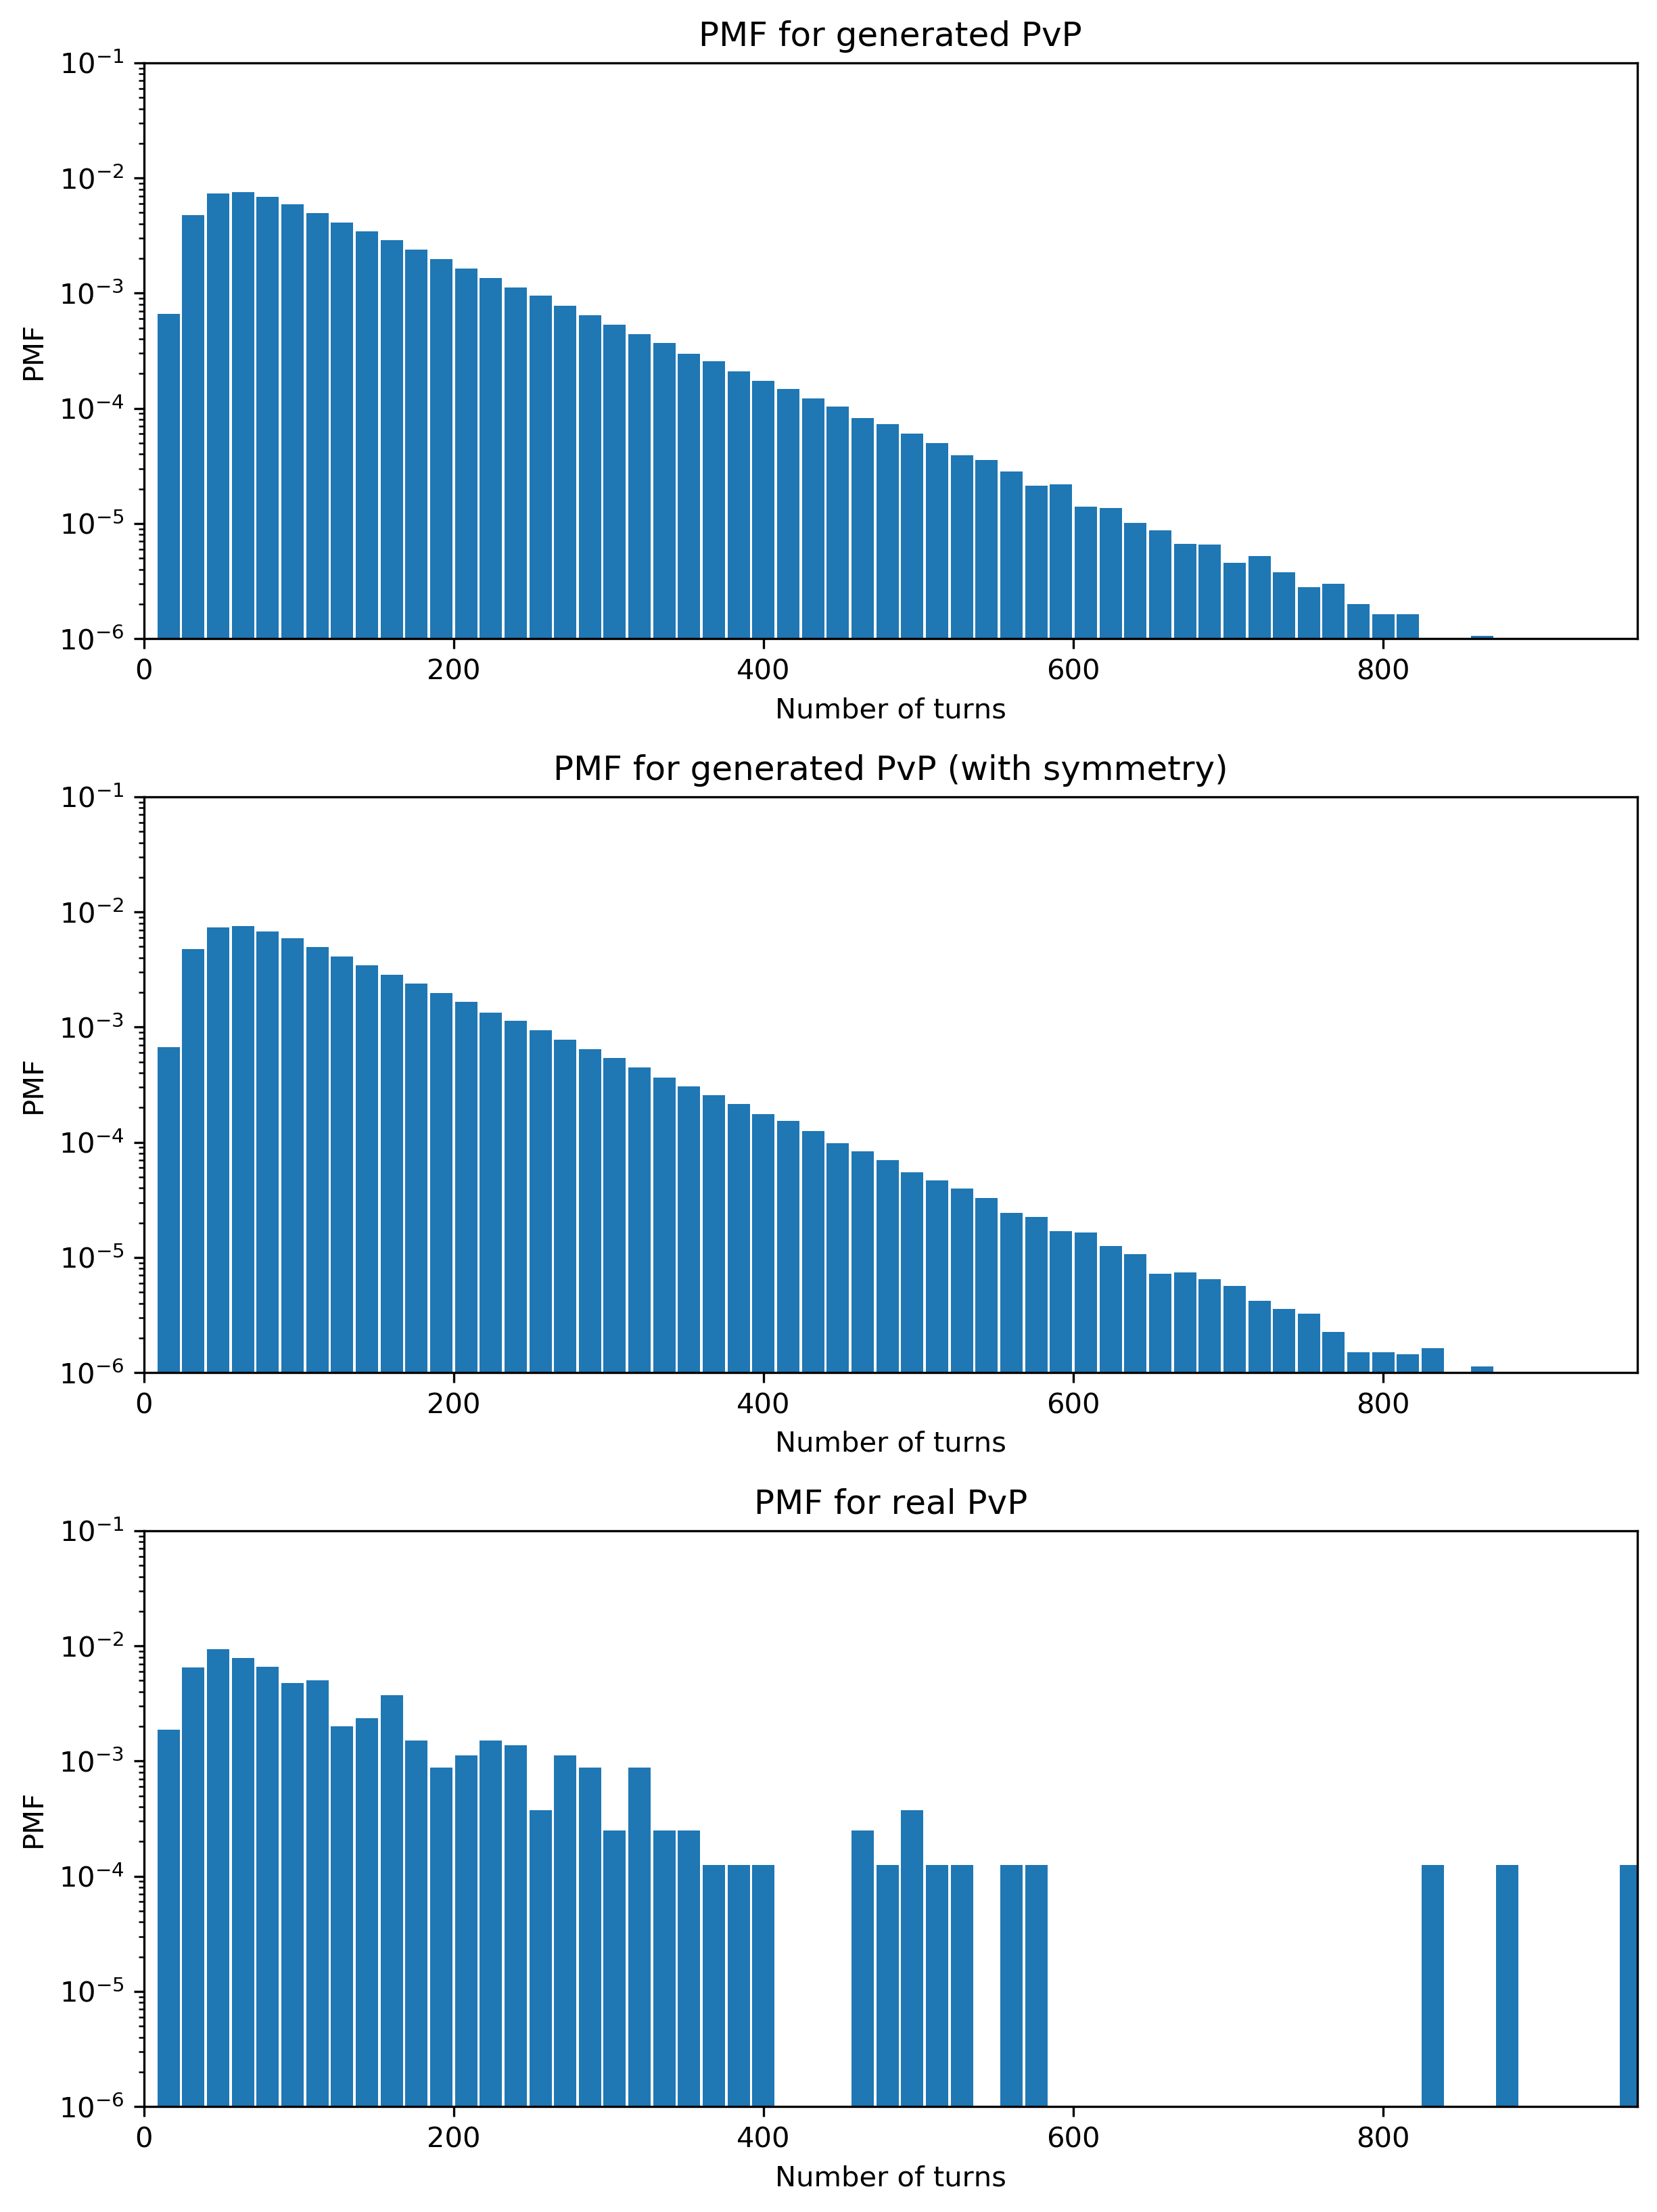

In [14]:
fig, axes = plt.subplots(3, figsize=(8.27, 11))
plt.rcParams['figure.dpi'] = 300
max_x = max(pvp_games_turns)

axes[0].set_yscale("log")
axes[0].set_xlabel("Number of turns")
axes[0].set_ylabel("PMF")
axes[0].set_title("PMF for generated PvP")
axes[0].set_ylim(ymin = 0.000001, ymax = 0.1)
axes[0].set_xlim(xmin = 0, xmax = max_x)
n_pvp_gen, bins_pvp_gen, patches_pvp_gen = axes[0].hist(gen_turns, 
                                                        bins=bins_ranges, 
                                                        rwidth=0.9, density=True) 
axes[1].set_yscale("log")
axes[1].set_xlabel("Number of turns")
axes[1].set_ylabel("PMF")
axes[1].set_title("PMF for generated PvP (with symmetry)")
axes[1].set_ylim(ymin = 0.000001, ymax = 0.1)
axes[1].set_xlim(xmin = 0, xmax = max_x)
n_pvp_gen_symm, bins_pvp_gen_symm, patches_pvp_gen_symm = axes[1].hist(gen_turns_symm, 
                                                                       bins=bins_ranges, 
                                                                       rwidth=0.9, density=True) 
axes[2].set_yscale("log")
axes[2].set_xlabel("Number of turns")
axes[2].set_ylabel("PMF")
axes[2].set_title("PMF for real PvP")
axes[2].set_ylim(ymin = 0.000001, ymax = 0.1)
axes[2].set_xlim(xmin = 0, xmax = max_x)
n_pvp, bins_pvp, patches_pvp = axes[2].hist(pvp_games_turns, 
                                            bins=bins_ranges, 
                                            rwidth=0.9, density=True)
fig.tight_layout()
plt.show()

In [15]:
xs_sampling = []
ys_sampling = []
for i in range (0, len(bins_pvp_gen_symm) - 1):
    xs_sampling.append(bins_pvp_gen_symm[i] + (bins_pvp_gen_symm[i + 1] - bins_pvp_gen_symm[i]) / 2)
ys_sampling = n_pvp_gen_symm

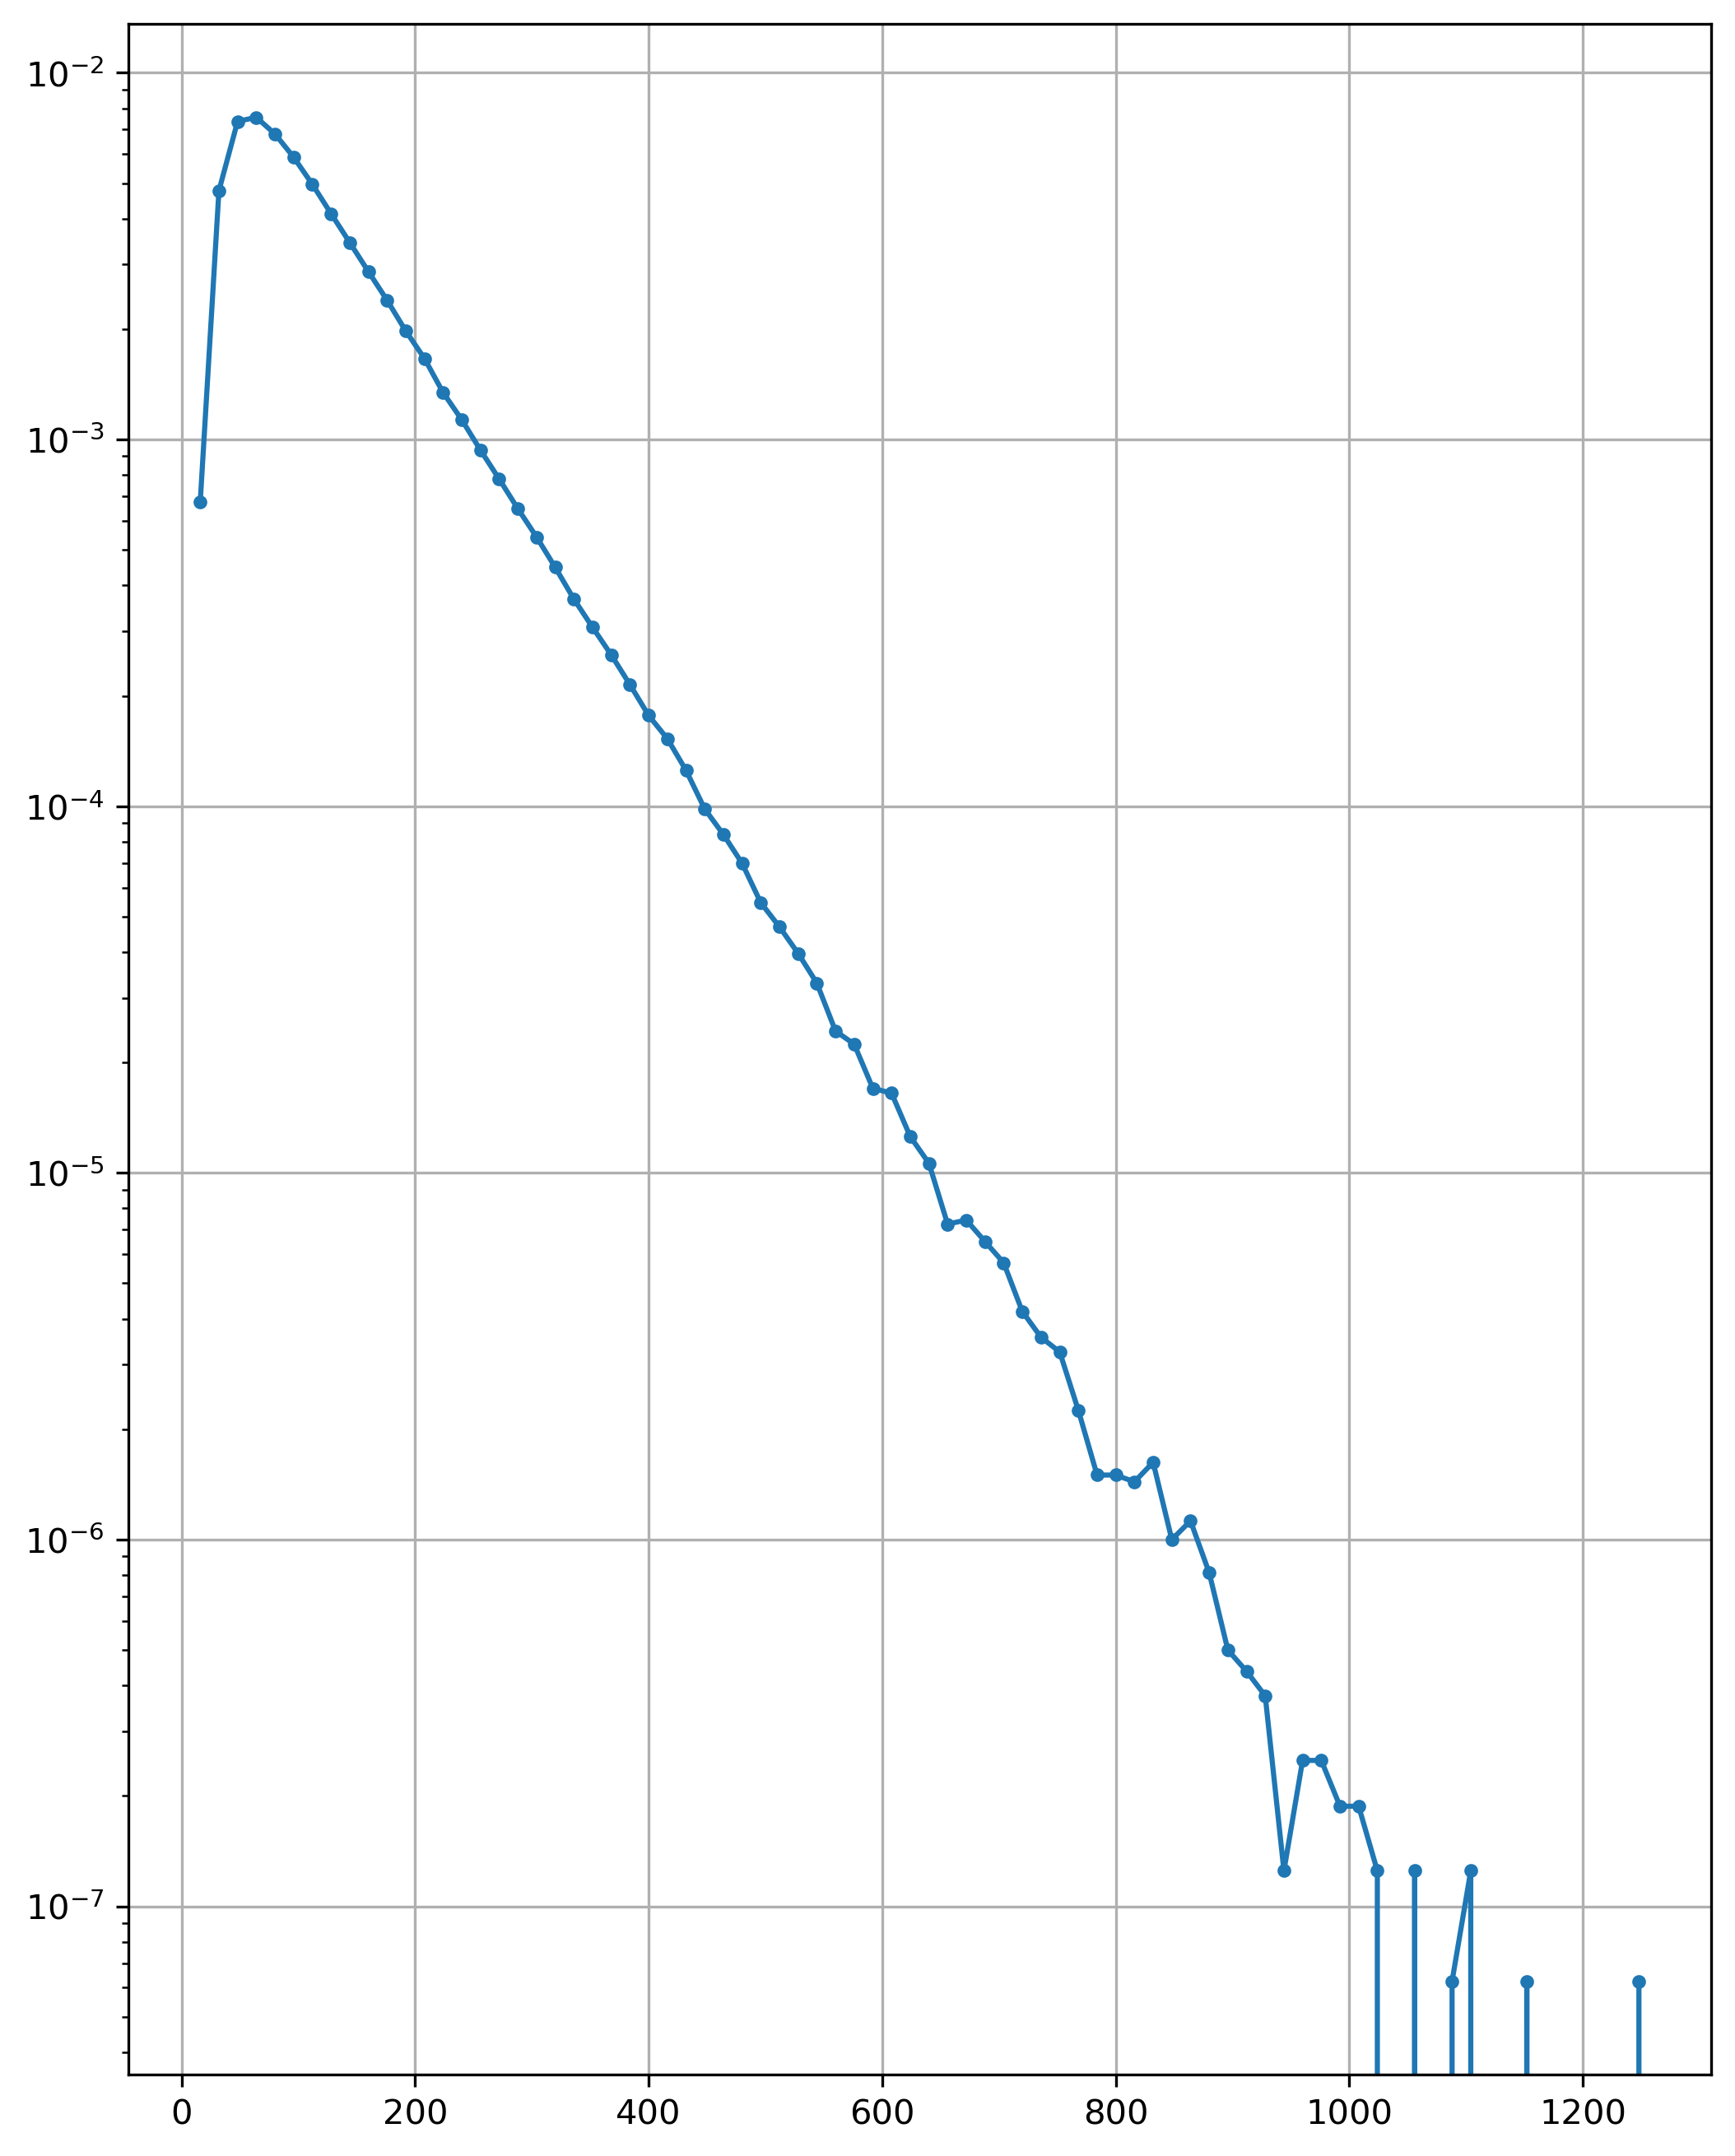

In [16]:
plt.rcParams['figure.figsize']=(8.27, 11)
plt.rcParams['figure.dpi'] = 300
#plt.xlim(0, 400)
#plt.xticks(xs_sampling[0:16])
plt.grid()
plt.plot(xs_sampling, ys_sampling,'.-')
plt.yscale("log")
plt.show()

In [16]:
from model_pvp import model_pvp

In [17]:
d, prob, (even, odd) = model_pvp(N, qr)
d_symm, prob_symm, (even_symm, odd_symm) = model_pvp(N, qr_symm)

In [18]:
print(sum(d))
print(sum(d_symm))

120.59919839679355
120.59919839679327


In [19]:
print(even)
print(odd)
print(even_symm)
print(odd_symm)

0.3527054108216414
0.647294589178356
0.3527054108216419
0.6472945891783551


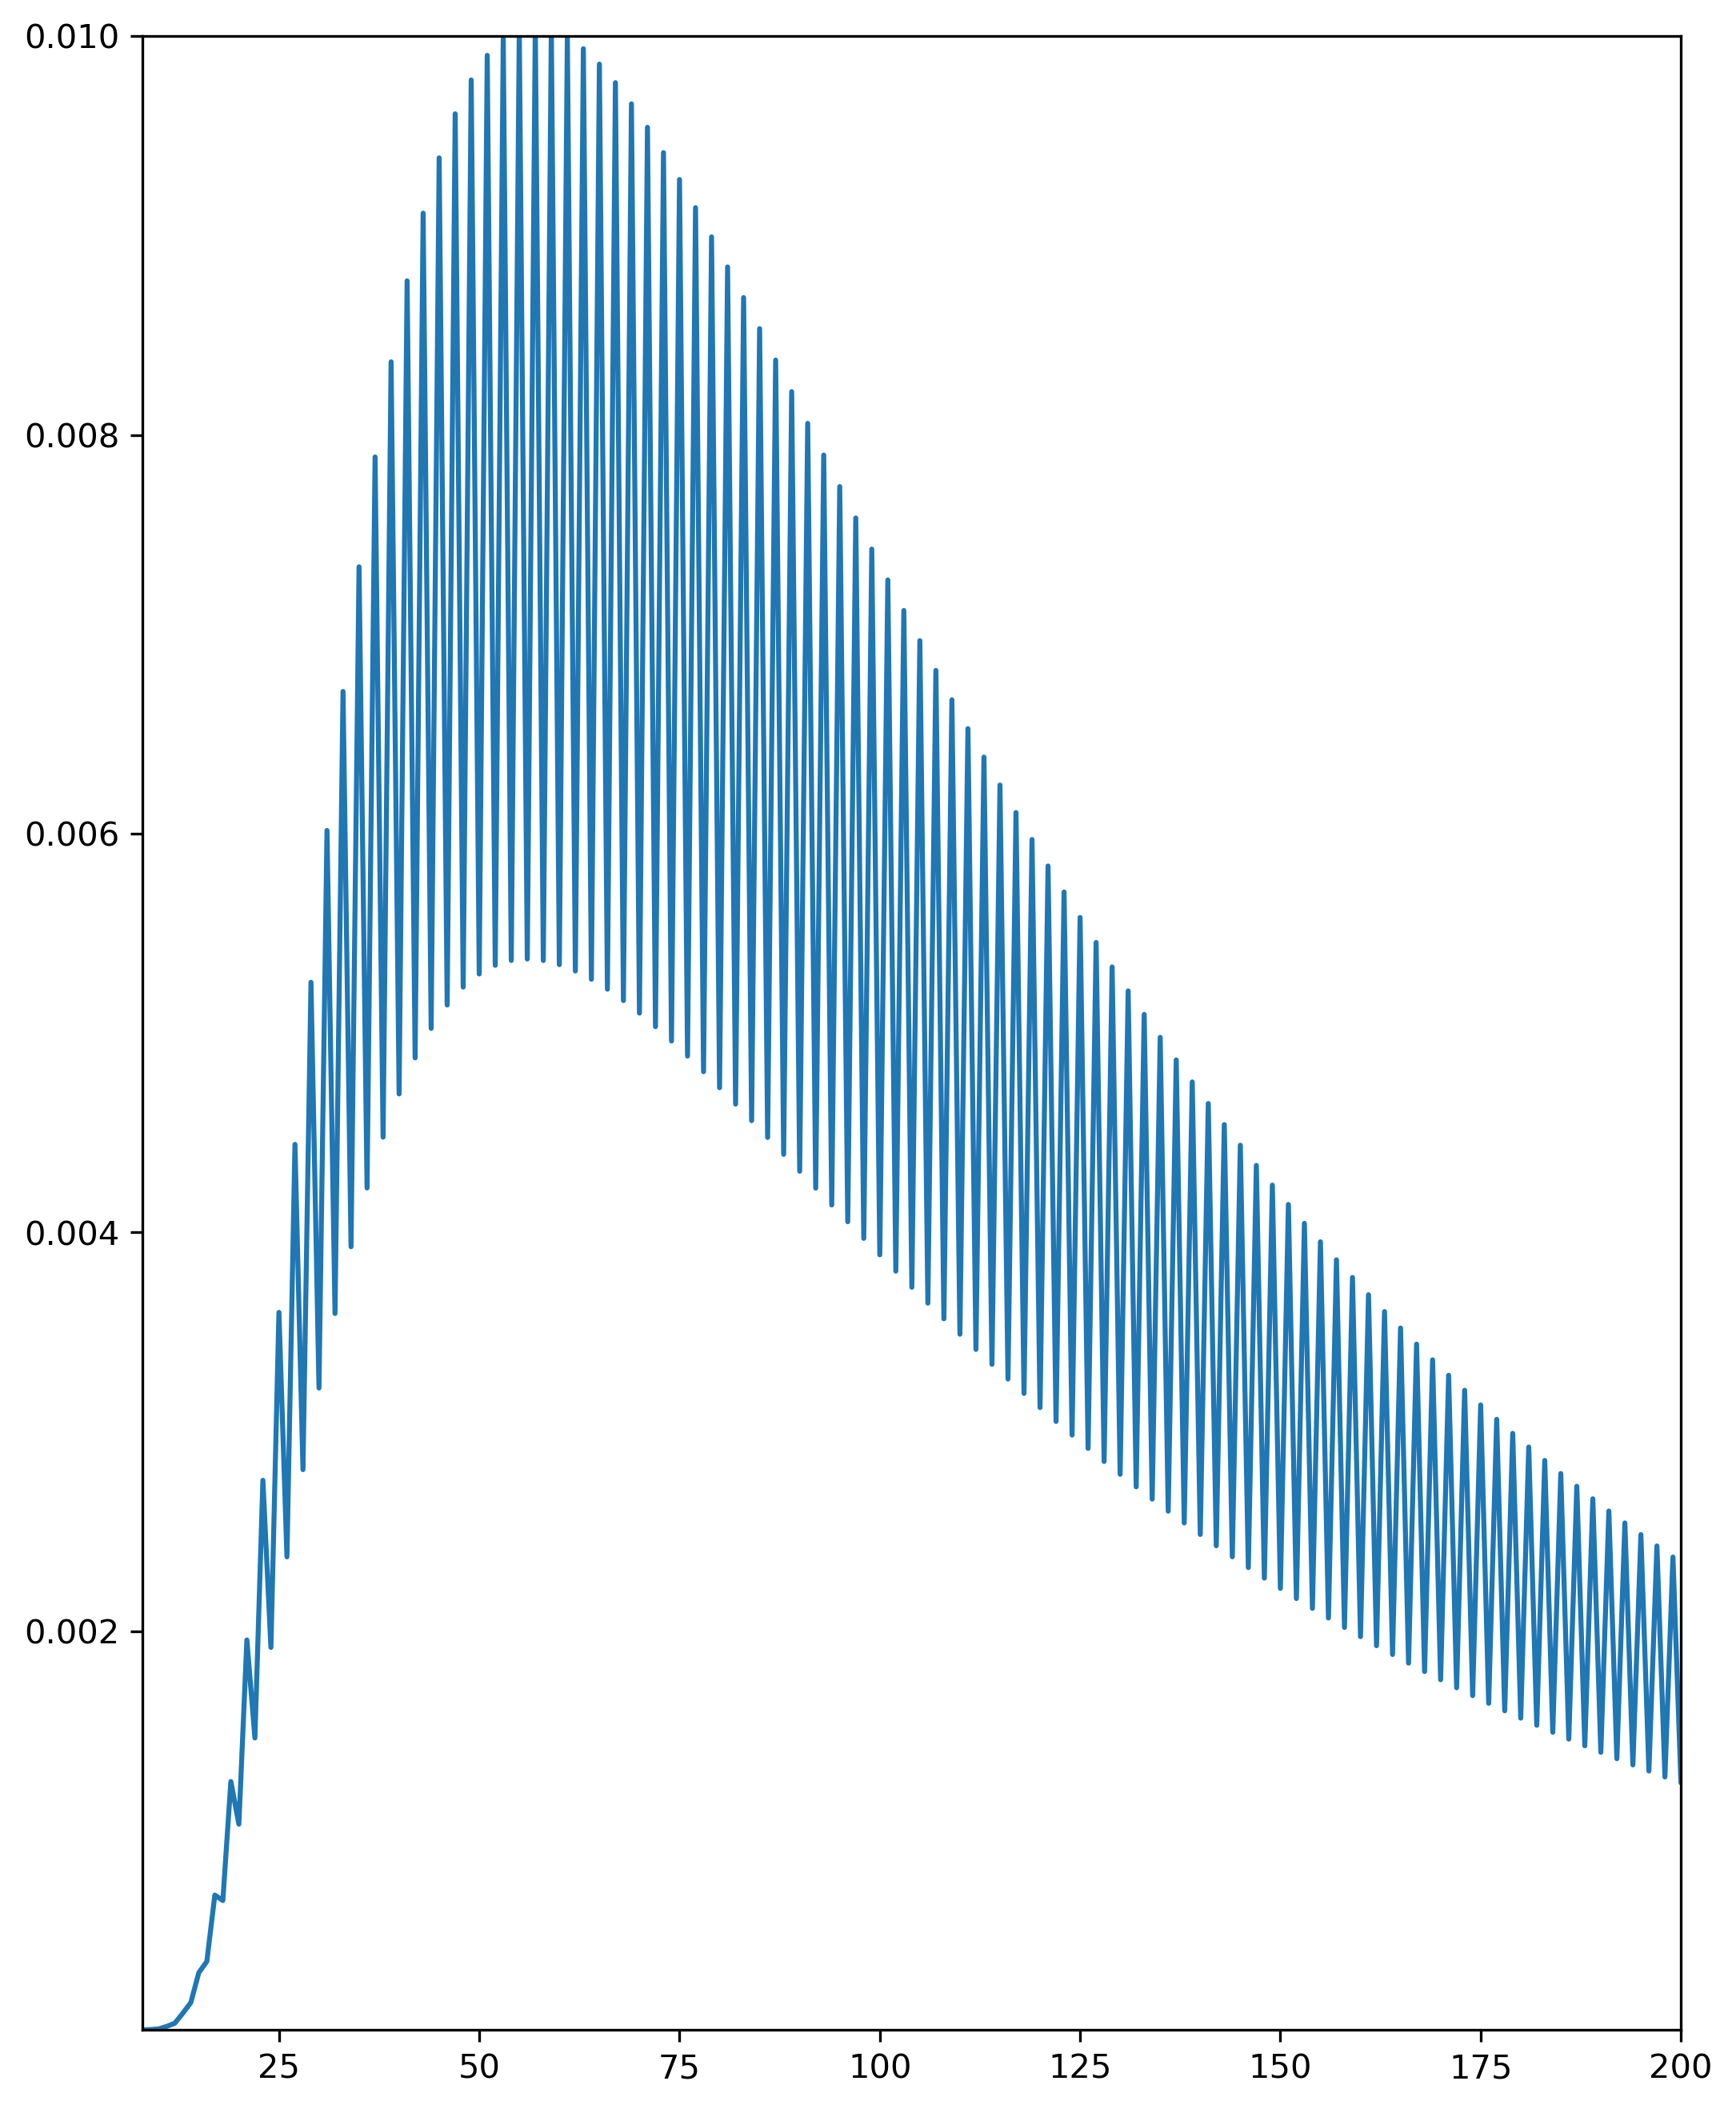

In [21]:
plt.plot(prob)
plt.xlim([8, 200])
plt.ylim(ymin = 0.000001, ymax = 0.01)
#plt.yscale("log")
plt.show()

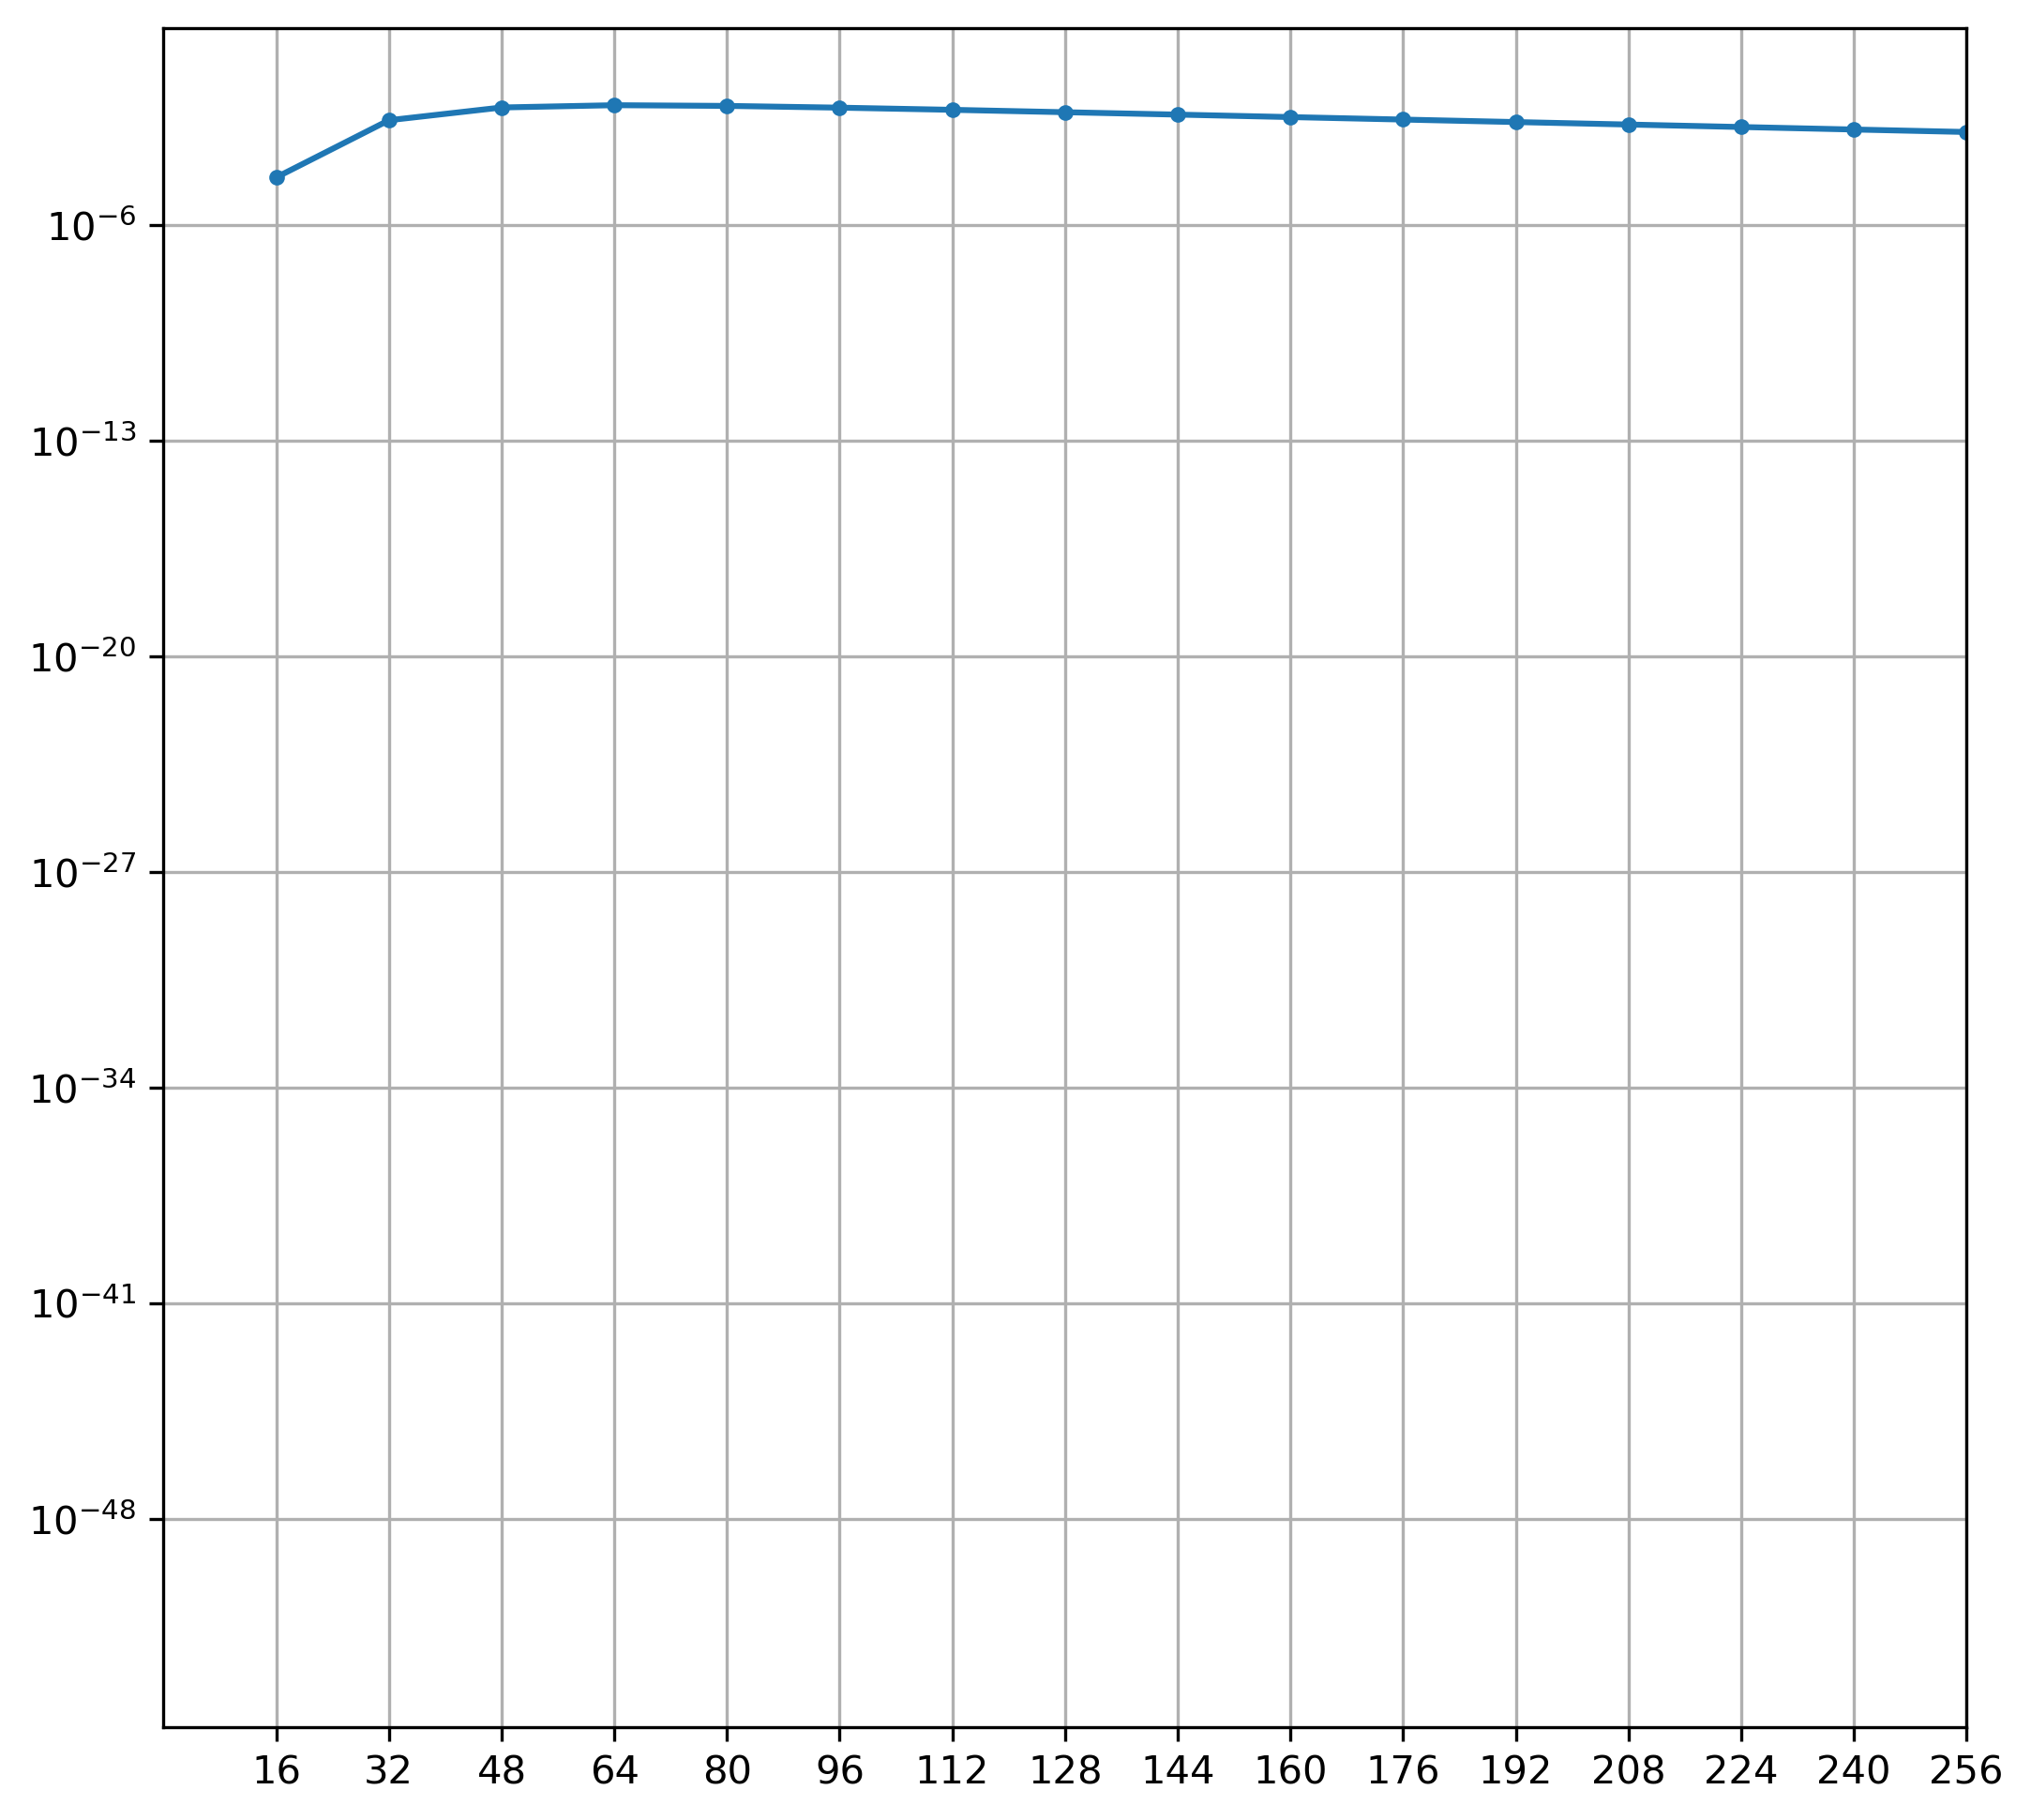

In [22]:
plt.rcParams['figure.figsize']=(8.27, 8)
plt.rcParams['figure.dpi'] = 300
plt.xlim(0, 200)

plt.grid()

xs = []
ys = []
x0 = 8 + bin_width / 2
for i in range (0, len(prob) // bin_width):
    xs.append(x0 + bin_width * i)
for i in range (0, len(prob_symm) // bin_width):
    ys.append(sum(prob_symm[bin_width * i : bin_width * (i + 1)]) / bin_width)
plt.plot(xs, ys,'.-')
plt.yscale("log")
plt.xticks(xs[0:16])
plt.show()

In [23]:
start_point = 40
end_point = 400

pvp_count = []
uniques = np.array(gen_turns)
uniques = np.unique(uniques)
for i in uniques:
    pvp_count.append(gen_turns.count(i) / len(gen_turns))
    
pvp_count_symm = []
uniques_symm = np.array(gen_turns_symm)
uniques_symm = np.unique(uniques)
for i in uniques:
    pvp_count_symm.append(gen_turns_symm.count(i) / len(gen_turns_symm))

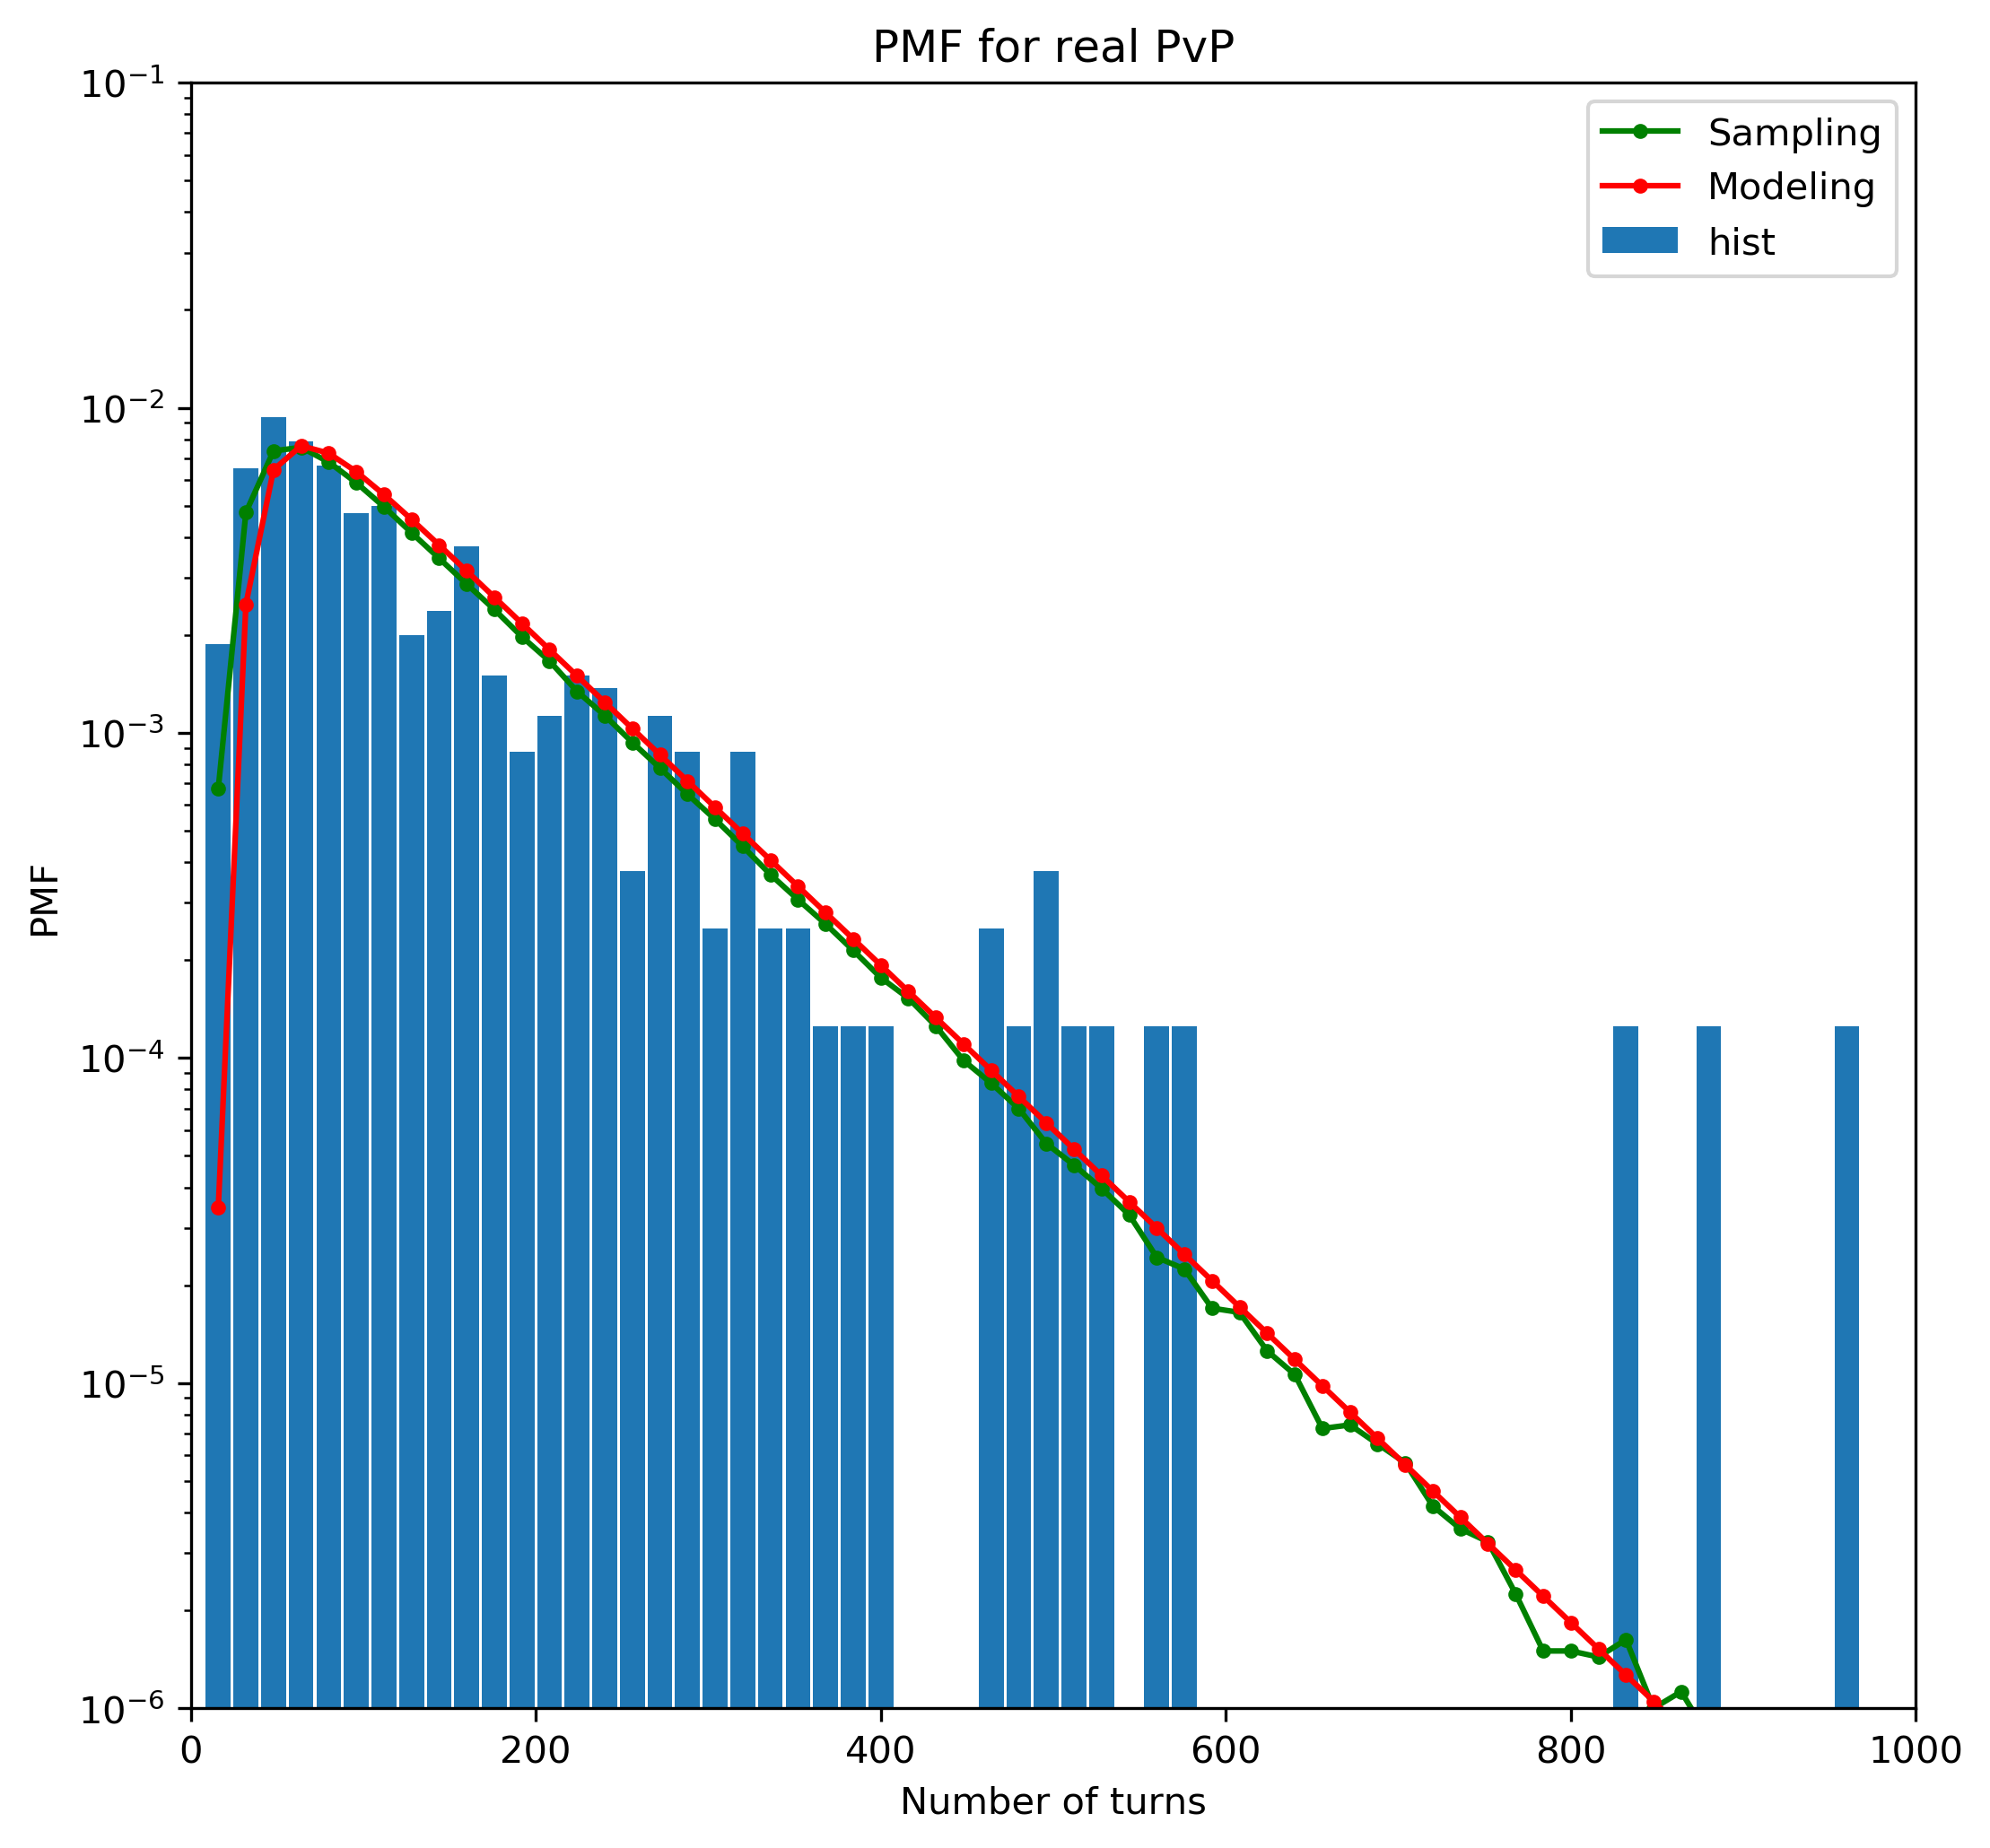

In [24]:
#plt.plot(uniques, pvp_count)
#plt.plot(uniques, pvp_count, 'g.', label="Sampling")
plt.plot(xs_sampling, ys_sampling, 'g.-', label="Sampling")
plt.xlim([0, 1000])



plt.yscale("log")
plt.xlabel("Number of turns")
plt.ylabel("PMF")
plt.title("PMF for real PvP")
plt.ylim(ymin = 0.000001, ymax = 0.1)
n_pvp, bins_pvp, patches_pvp = plt.hist(pvp_games_turns, 
                                            bins=bins_ranges, 
                                            rwidth=0.9, density=True, label="hist")

#plt.plot(prob, 'r.', label="Modeling")
plt.plot(xs, ys, 'r.-', label="Modeling")
plt.legend()
#pvp_count = np.array(pvp_count)
#pvp_count = pvp_count / sum(pvp_count)
plt.show()

In [25]:
xs_ys = [[],[]]
xs_ys[0].append("x")
xs_ys[1].append("y")
xs_ys[0].extend(xs)
xs_ys[1].extend(ys)
xs_ys = np.array(xs_ys)
xs_ys = np.transpose(xs_ys)

In [26]:
with open("../csv/pvp_model.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(xs_ys)

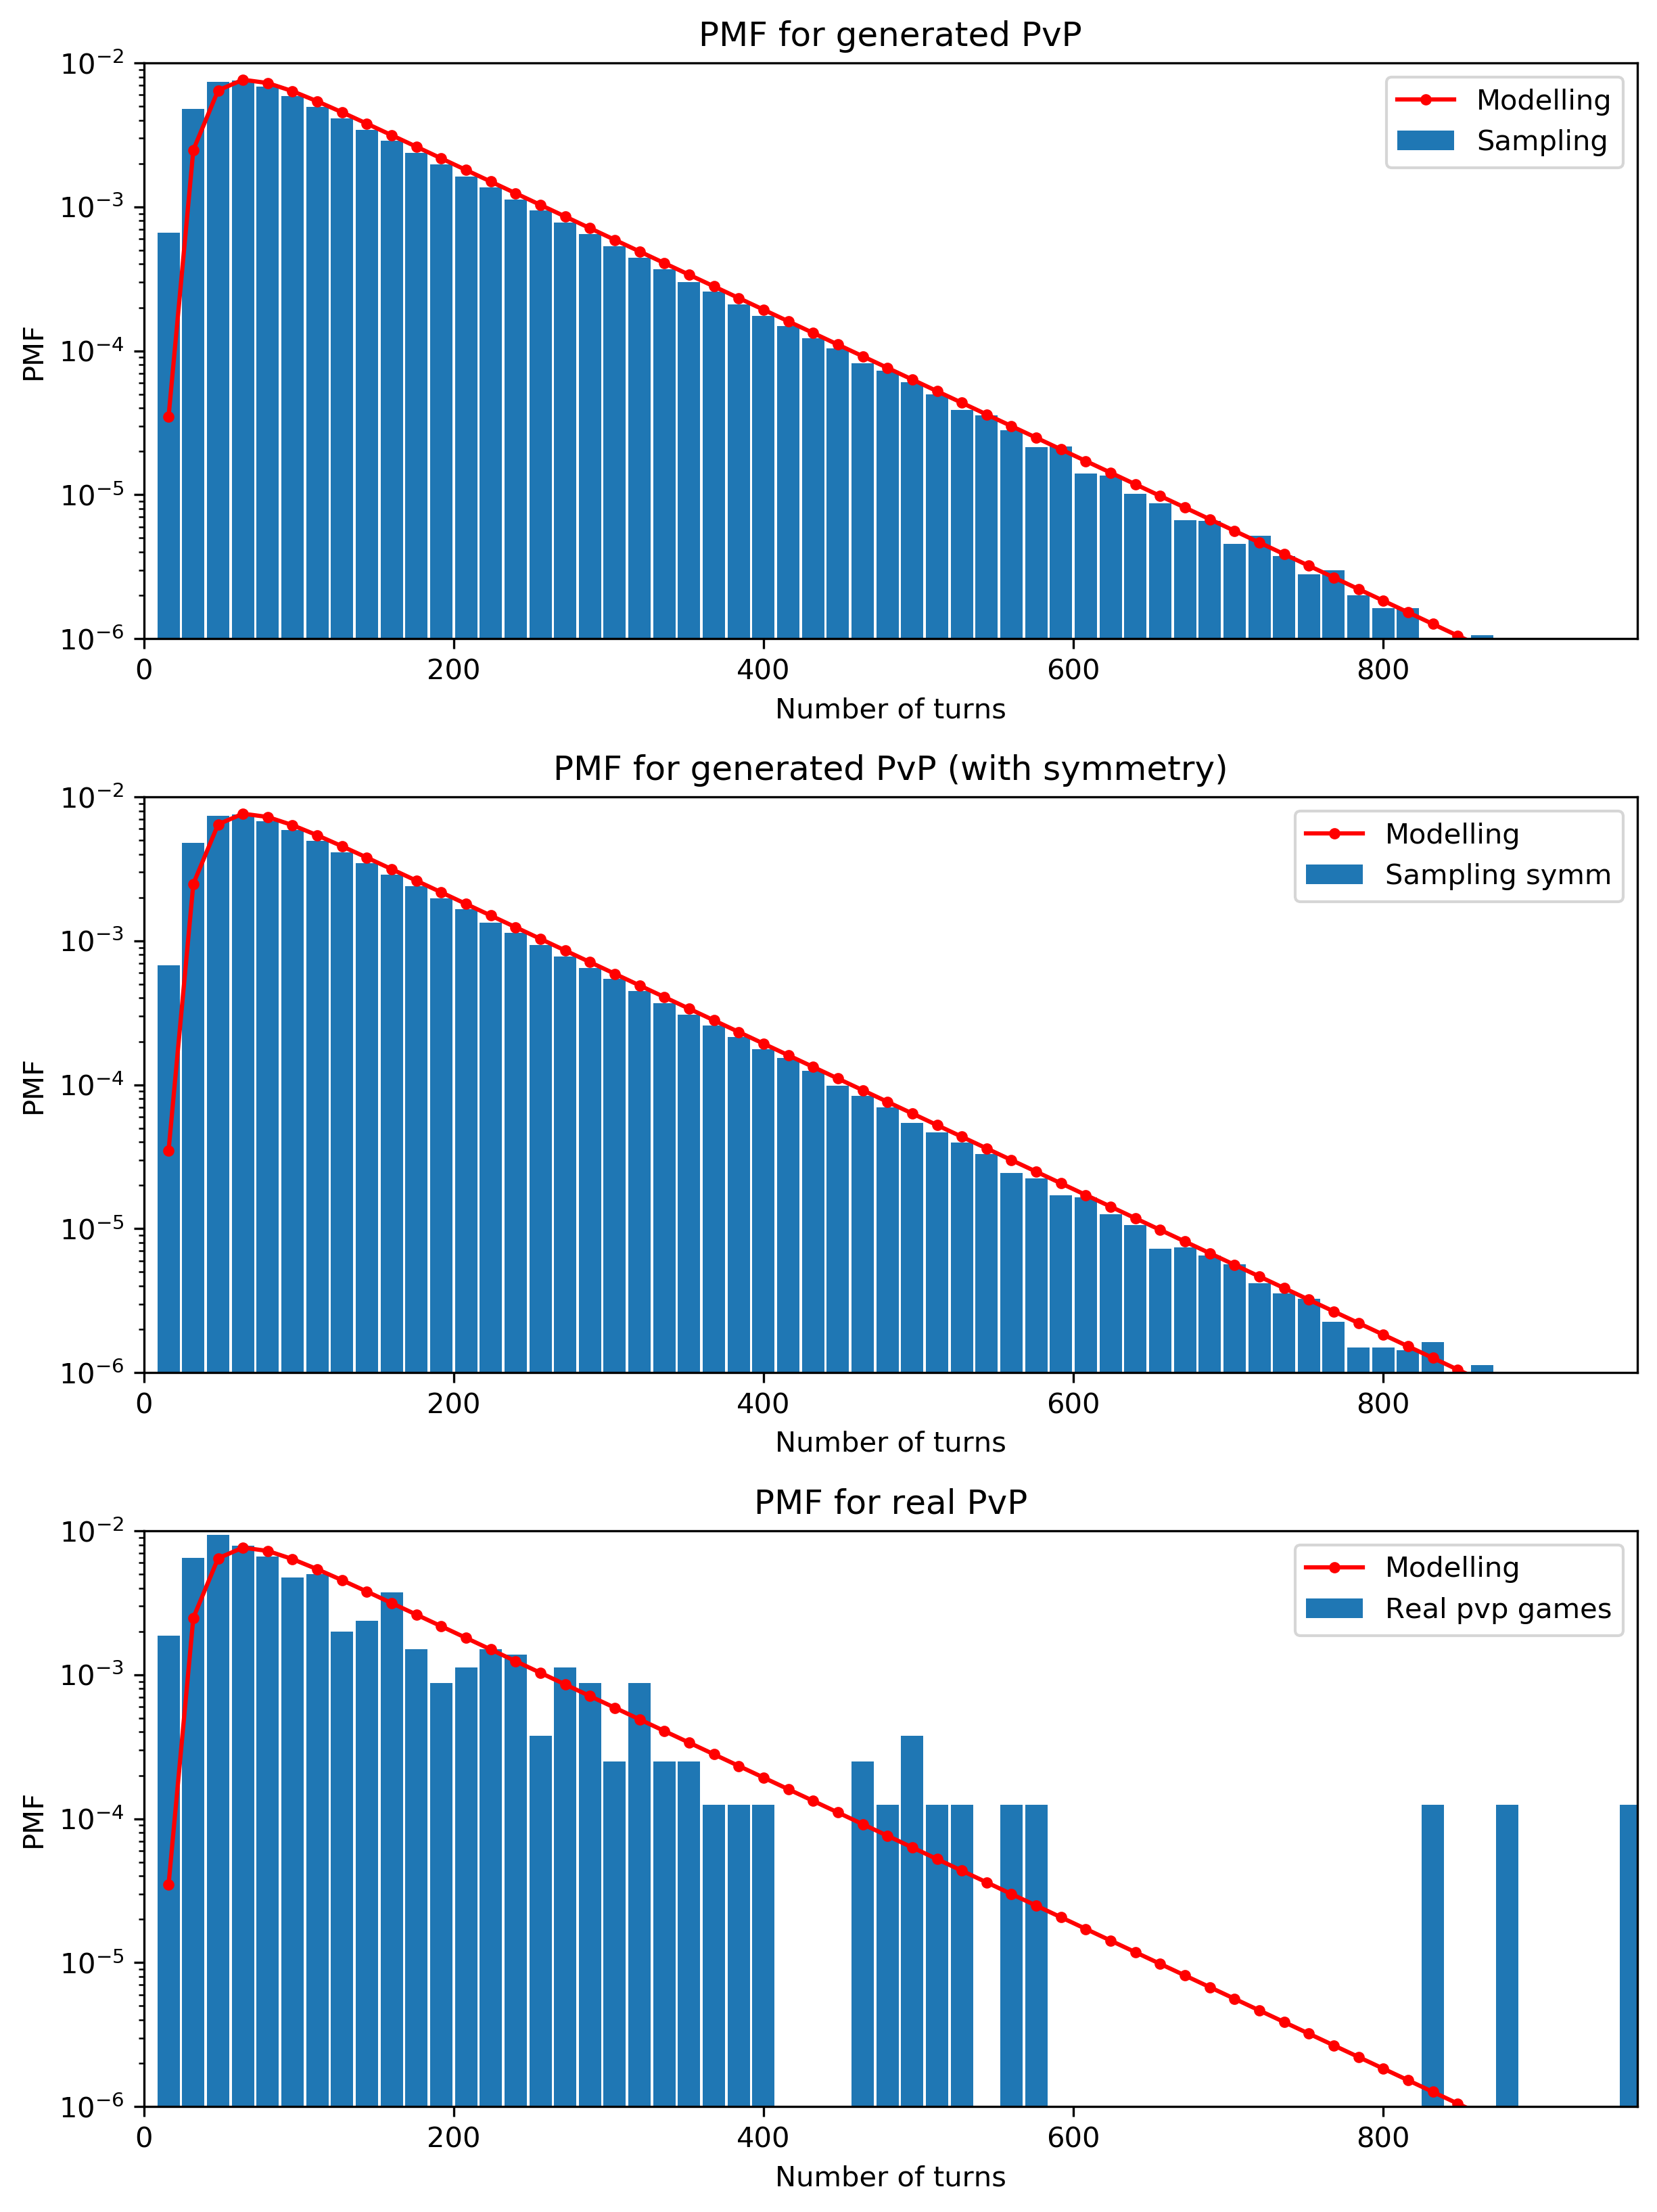

In [27]:
fig, axes = plt.subplots(3, figsize=(8.27, 11))
plt.rcParams['figure.dpi'] = 300
max_x = max(pvp_games_turns)

axes[0].set_yscale("log")
axes[0].set_xlabel("Number of turns")
axes[0].set_ylabel("PMF")
axes[0].set_title("PMF for generated PvP")
axes[0].set_ylim(ymin = 0.000001, ymax = 0.01)
axes[0].set_xlim(xmin = 0, xmax = max_x)
n_pvp_gen, bins_pvp_gen, patches_pvp_gen = axes[0].hist(gen_turns, 
                                                        bins=bins_ranges, 
                                                        rwidth=0.9, density=True, label="Sampling") 
axes[0].plot(xs, ys, 'r.-', label="Modelling")
axes[0].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Number of turns")
axes[1].set_ylabel("PMF")
axes[1].set_title("PMF for generated PvP (with symmetry)")
axes[1].set_ylim(ymin = 0.000001, ymax = 0.01)
axes[1].set_xlim(xmin = 0, xmax = max_x)
n_pvp_gen_symm, bins_pvp_gen_symm, patches_pvp_gen_symm = axes[1].hist(gen_turns_symm, 
                                                                       bins=bins_ranges, 
                                                                       rwidth=0.9, density=True, label="Sampling symm") 
axes[1].plot(xs, ys, 'r.-', label="Modelling")
axes[1].legend()
axes[2].set_yscale("log")
axes[2].set_xlabel("Number of turns")
axes[2].set_ylabel("PMF")
axes[2].set_title("PMF for real PvP")
axes[2].set_ylim(ymin = 0.000001, ymax = 0.01)
axes[2].set_xlim(xmin = 0, xmax = max_x)
n_pvp, bins_pvp, patches_pvp = axes[2].hist(pvp_games_turns, 
                                            bins=bins_ranges, 
                                            rwidth=0.9, density=True, label="Real pvp games")
axes[2].plot(xs, ys, 'r.-', label="Modelling")
axes[2].legend()
fig.tight_layout()
plt.show()

In [28]:
from get_border_cases import get_border_cases